# CMPT 459 – Group 8


## How to use this notebook
1. Install dependencies: `pip install pandas numpy matplotlib seaborn scikit-learn`.
2. Data files (`cleaned_data.csv`, `ObesityDataSet_raw_and_data_sinthetic.csv`) are already in the repo.



## Summary
- **Clustering**: Hierarchical , DBSCAN with PCA reduction and grid over eps/min_samples, CLARANS medoid-based search.
- **Outlier detection**: k-NN distance , Gaussian Mixture, Local Outlier Factor.
- **Feature selection**: Mutual Information top-k (default k=8) + scaling; LASSO optional in pipeline.
- **Classification**: k-NN, Logistic Regression, Random Forest. All consume MI-selected features.
- **Hyperparameter tuning**: GridSearchCV for k-NN and Random Forest.


## Challenges
- We had too many columns after one-hot encoding, so we reduced them with PCA and by keeping only the most informative features.
- Some obesity categories were much rarer than others, so instead of deleting unusual rows we checked them with outlier detectors.
- To avoid flaky models, we validated them with cross-validation and tuned k-NN/Random Forest settings using grid search.

In [1]:
import os
from main import (
    load_and_split_data,
    clustering_analysis,
    outlier_detection,
    feature_selection,
    classification,
    hyperparameter_tuning,
)

Data Split:
Total Samples: 2087
Training Samples: 1252 (60%)
Validation Samples: 417 (20%)
Test Samples: 418 (20%)
1. CLUSTERING ANALYSIS
==== Hierarchical Clustering ====
Evaluating different number of clusters: 


Number of clusters: 3
Silhoutte score: 0.33998269276488635
Calinski-Harabasz score: 1580.7175904189555
Davies-Bouldin score: 0.9429671300218759


Number of clusters: 5
Silhoutte score: 0.29317409378632947
Calinski-Harabasz score: 1667.938096891051
Davies-Bouldin score: 1.0177072718636886


Number of clusters: 7
Silhoutte score: 0.27290097770997435
Calinski-Harabasz score: 1349.4563515418915
Davies-Bouldin score: 1.044584857312668


Number of clusters: 9
Silhoutte score: 0.20635207193295108
Calinski-Harabasz score: 1135.9508416940316
Davies-Bouldin score: 1.3148562449026917


Best number of clusters: 3

PCA Visualization:


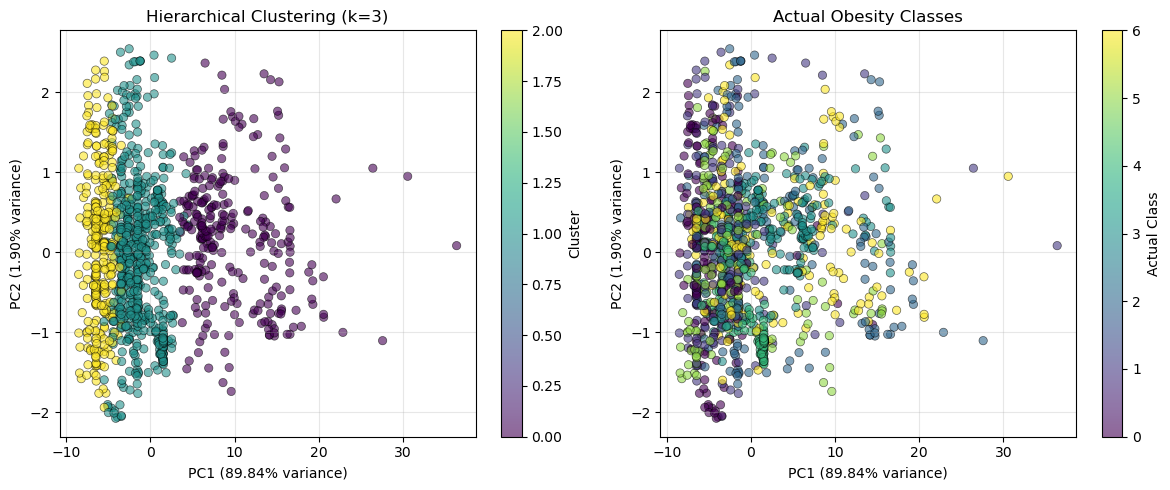


Cluster Characteristics:
Cluster 0 (n=270): Most common class = Obesity_Type_II
Cluster 1 (n=656): Most common class = Obesity_Type_III
Cluster 2 (n=326): Most common class = Insufficient_Weight

*** Hierarchical Clustering Analysis Discussion ***

 Note: while hierarchical clustering usually produces dendogram, but in here we specificy n_cluster for fair comparison with other clustering algorithms
Hierarchical clustering with Ward linkage fits this obesity dataset well because the points are grouped based on distances in the features and doesn't really need class labels to find structure. From the k values tested, k=3 achieved the highest silhouette score of 0.340 compare to k = 3 (0.124), k = 5 (0.185), k = 7 (0.217). Therefore, the algorithm and the PCA successfully identified 3 clusters that fit the major obesity categories. 

==== CLARANS Clustering ====
Evaluating clusters: [3, 5, 7, 9]
PCA reduction: 31 → 15 components (86.4% variance)

k=3: silhouette=0.135, calinski=105.3, da

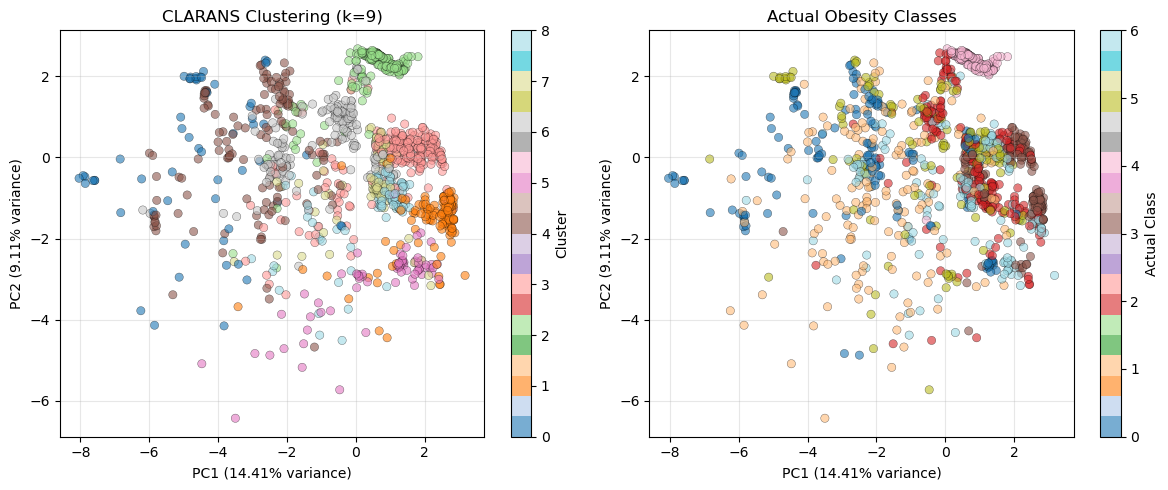

==== DBSCAN Clustering ====
Applied PCA: 31 features → 15 components (86.4% variance)
Testing eps range: [6.0, 6.1, 6.2]
Testing min_samples: [17, 18, 19]

Evaluating different parameter combinations:

Top 4 Configurations (by Silhouette Score):

Rank #1:
  eps: 6.1
  min_samples: 18
  Silhouette: 0.41101567169985836
  Clusters: 3
  Noise: 59 (0.04712460063897764)

Rank #2:
  eps: 6.1
  min_samples: 17
  Silhouette: 0.4108997739227786
  Clusters: 3
  Noise: 57 (0.04552715654952077)

Rank #3:
  eps: 6.2
  min_samples: 18
  Silhouette: 0.41040684880812156
  Clusters: 3
  Noise: 58 (0.0463258785942492)

Rank #4:
  eps: 6.0
  min_samples: 17
  Silhouette: 0.4103324007739097
  Clusters: 3
  Noise: 62 (0.04952076677316294)

Selected Best Configuration:
  eps: 6.1
  min_samples: 18
  Number of clusters: 3
  Silhouette score: 0.41101567169985836
  Calinski-Harabasz score: 123.70921523905056
  Davies-Bouldin score: 1.002306284344727
  Noise points: 59 (0.047)

PCA Visualization:


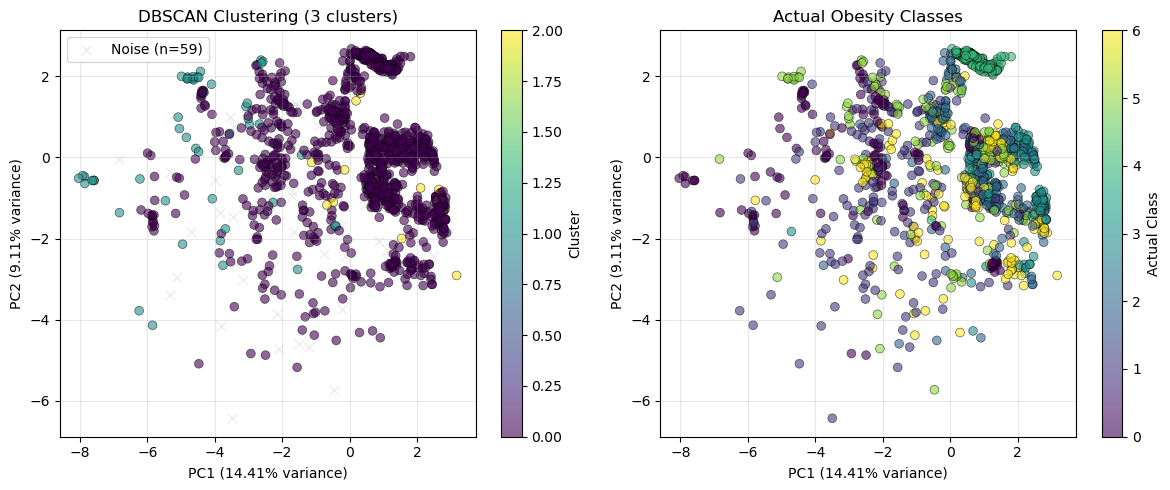


Noise (n=59): Potential outliers or rare patterns
Cluster 0 (n=1125, 89.9%): Obesity_Type_I
Cluster 1 (n=50, 4.0%): Overweight_Level_I
Cluster 2 (n=18, 1.4%): Obesity_Type_II

*** DBSCAN Clustering Analysis Discussion ***

Data Preprocessing:
  • One-hot encoding expanded 8 categorical features into 31 binary features, creating sparsity that complicates distance-based calculations.
  • PCA reduced dimensionality from 31 to 15 components (retaining 86.4% variance) to combat the curse of dimensionality.

Why PCA is Essential for DBSCAN:
  • In high-dimensional spaces, distances between nearest and farthest points become nearly equal, making density measurement unreliable.
  • PCA focuses on variance-capturing dimensions, enabling better clustering quality and more reliable hyperparameter selection.

DBSCAN Algorithm:
  • DBSCAN is a density-based algorithm that identified 3 clusters by grouping points in dense regions, naturally capturing major obesity categories.

Parameter Selection:


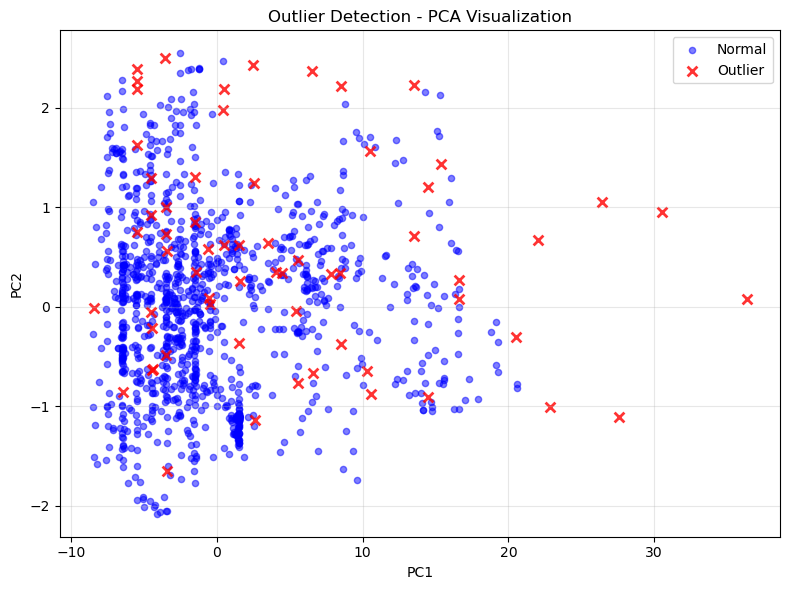


Outlier Distribution by Obesity Class:
  • Insufficient_Weight: 6/159 (3.77%)
  • Normal_Weight: 33/160 (20.62%)
  • Obesity_Type_I: 3/224 (1.34%)
  • Obesity_Type_II: 2/178 (1.12%)
  • Obesity_Type_III: 0/193 (0.00%)
  • Overweight_Level_I: 7/159 (4.40%)
  • Overweight_Level_II: 12/179 (6.70%)

Outlier Analysis:

We going to keep all the data since outliers mostly represent unusual but valid combinations of features (including extreme normal-weight and obese cases).


==== Probabilistic Outlier Detection (Gaussian Mixture Model) ====
Using 3 Gaussian components

Outlier Detection Results:
  • Threshold (5th percentile log-likelihood): 48.9908
  • Outliers detected: 63 (5.03%)
  • Normal samples: 1189
  • EM algorithm converged: True

Visualizing outliers


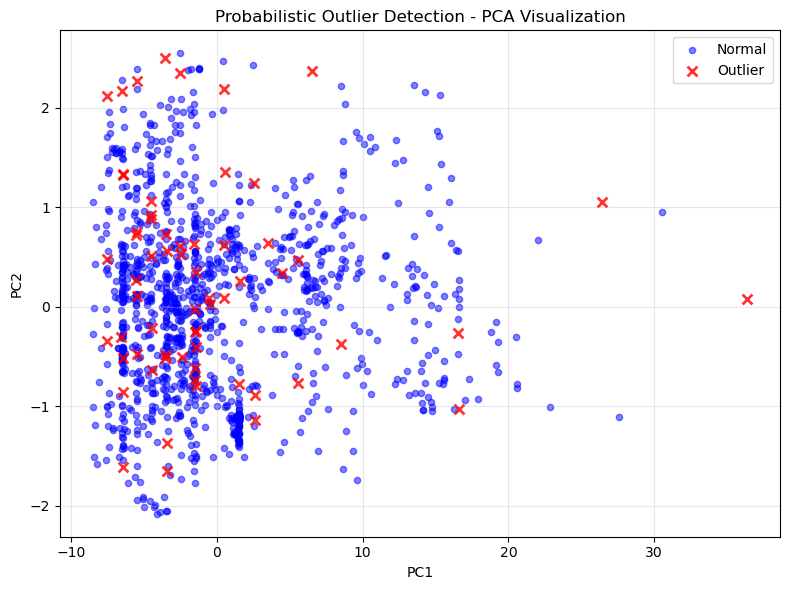


Outlier Distribution by Obesity Class:
  • Insufficient_Weight: 6/159 (3.77%)
  • Normal_Weight: 29/160 (18.12%)
  • Obesity_Type_I: 7/224 (3.12%)
  • Obesity_Type_II: 4/178 (2.25%)
  • Obesity_Type_III: 0/193 (0.00%)
  • Overweight_Level_I: 11/159 (6.92%)
  • Overweight_Level_II: 6/179 (3.35%)

Outlier Analysis:
Probabilistic outliers represent samples with low probability under the learned Gaussian mixture.
These are data points that deviate significantly from the typical patterns in the obesity dataset.

Decision: Keep outliers for analysis as they represent valid edge cases and rare obesity patterns
that could be important for understanding the full spectrum of obesity-related features.


==== LOF Outlier Detection ====
Using n_neighbors=20, contamination=0.05

Outlier Detection Results:
  • Score threshold (approx.): 1.5672
  • Outliers detected: 63 (5.03%)
  • Normal samples: 1189

Visualizing outliers


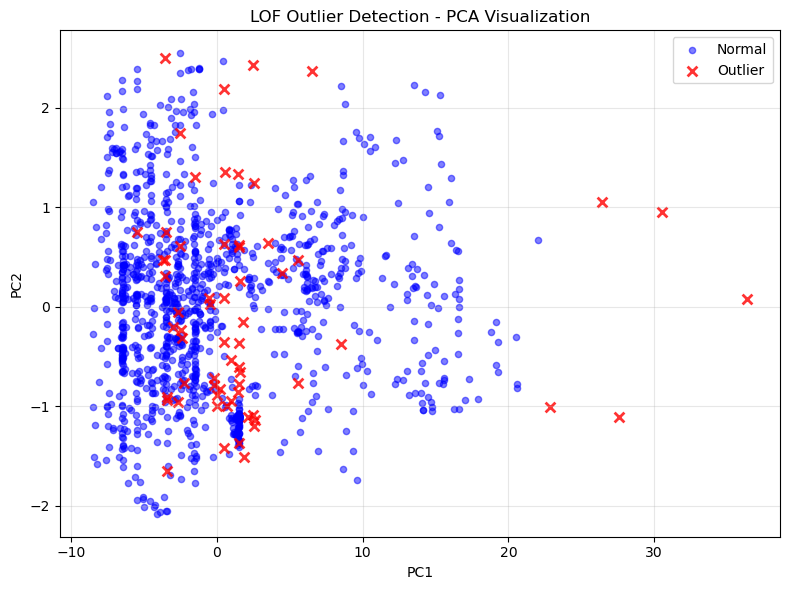


Outlier Distribution by Obesity Class:
  • Insufficient_Weight: 1/159 (0.63%)
  • Normal_Weight: 25/160 (15.62%)
  • Obesity_Type_I: 4/224 (1.79%)
  • Obesity_Type_II: 1/178 (0.56%)
  • Obesity_Type_III: 9/193 (4.66%)
  • Overweight_Level_I: 12/159 (7.55%)
  • Overweight_Level_II: 11/179 (6.15%)
3. FEATURE SELECTION

 ==== Mutual Information Feature Selection ====

Top 10 Most Important Features:
                          Feature  MI_Score
                           Weight  1.215585
                              Age  0.546706
                             FCVC  0.378572
                           Height  0.377123
                             CH2O  0.301046
                              TUE  0.278102
                              FAF  0.259247
                              NCP  0.219744
                    Gender_Female  0.213903
family_history_with_overweight_no  0.211317

Feature Importance Distribution:
High importance or > median: 15 features
Low importance or <= median: 16 features

/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(


Cross-validation selected alpha=0.0100
This selects 21/31 features (67.7%)

Top 10 Most Important Features (by Lasso coefficients):
                          Feature  Importance
                           Weight    0.524131
                  CAEC_Frequently    0.400731
family_history_with_overweight_no    0.303363
                              Age    0.209236
                           Height    0.200811
                          FAVC_no    0.133881
                  CALC_Frequently    0.131717
                              NCP    0.120342
                          CALC_no    0.114023
                 MTRANS_Motorbike    0.084612

Feature Selection Results:
Selected features: 21/31 (67.7%)
Features eliminated: 10

Selected features:
  1. Age                            (importance: 0.2092)
  2. Height                         (importance: 0.2008)
  3. Weight                         (importance: 0.5241)
  4. FCVC                           (importance: 0.0790)
  5. NCP                     

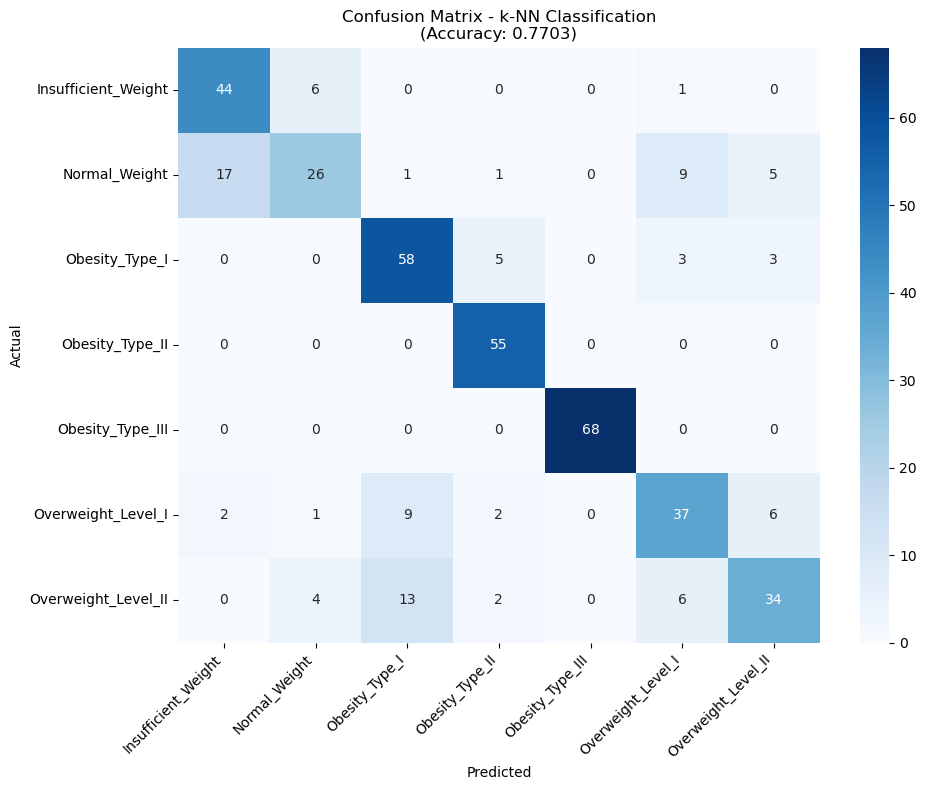

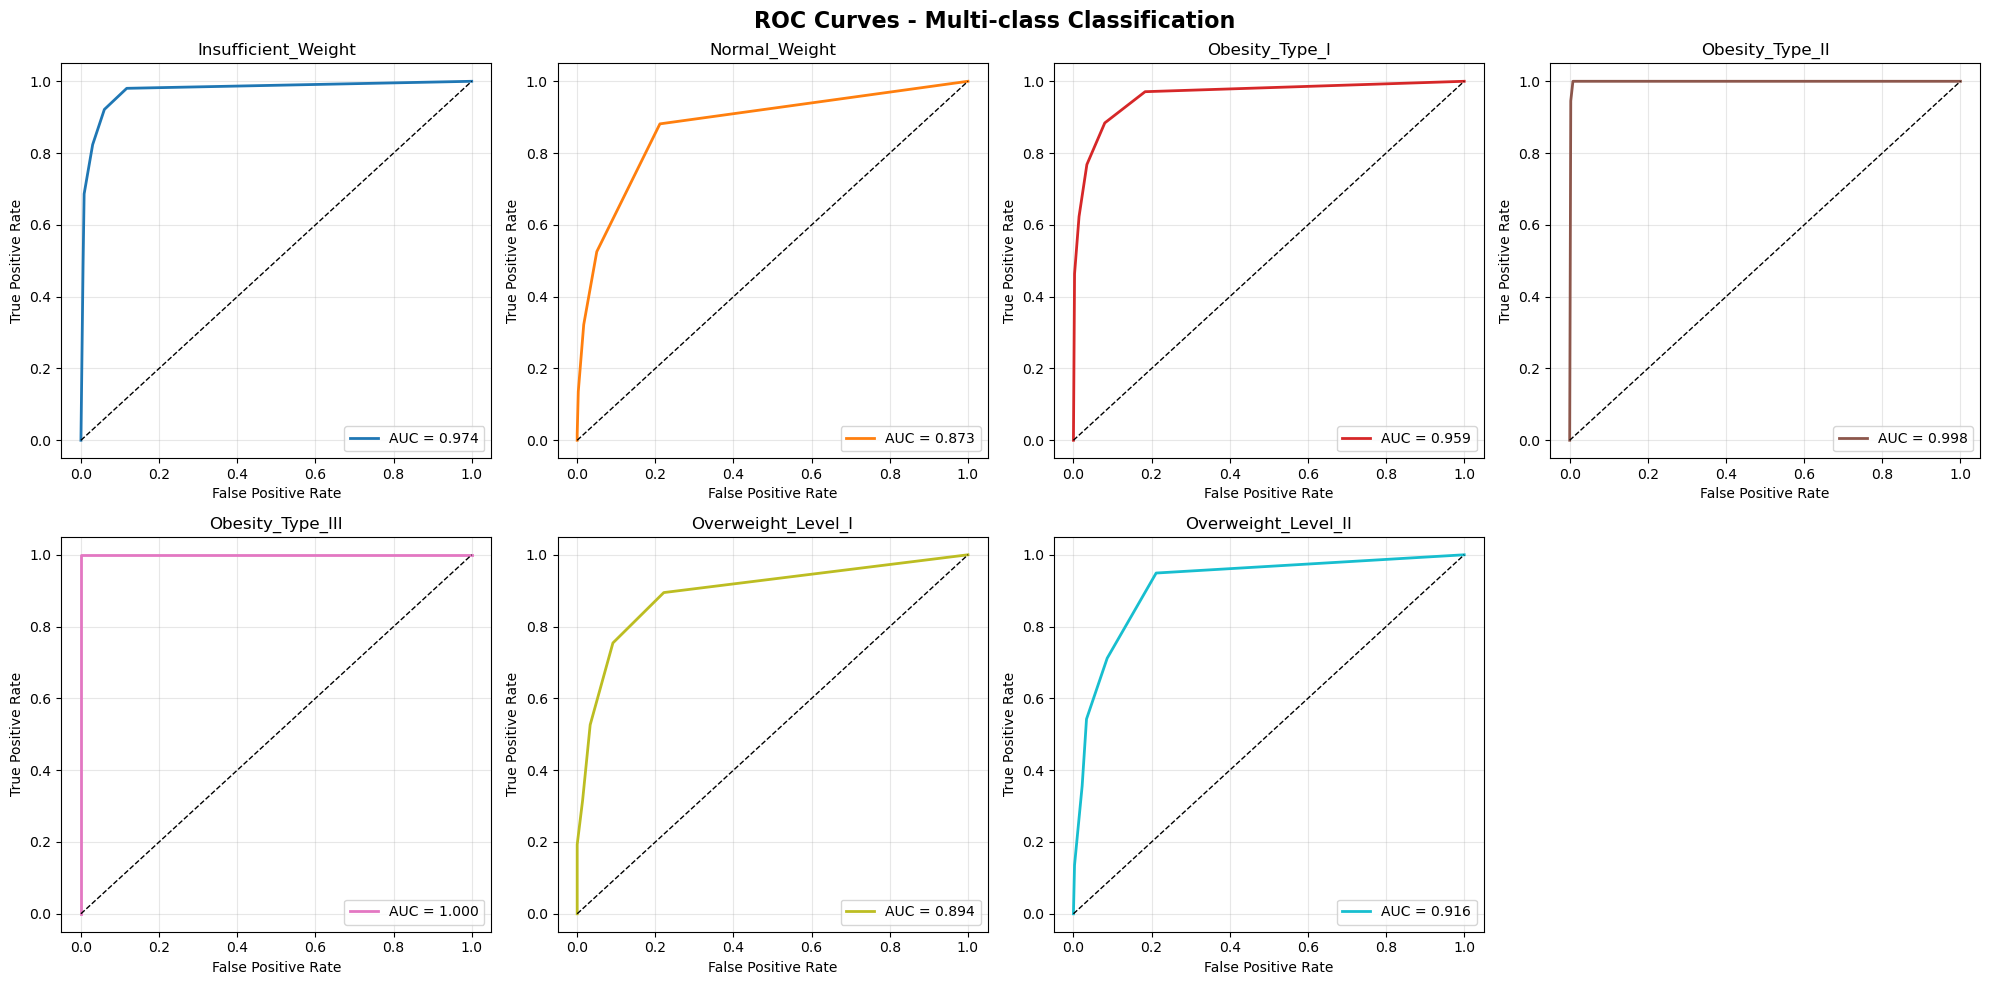


==== Logistic Regression Classification ====
Note: Features are standardized (mean=0, std=1) for logistic regression

Classification Metrics (Logistic Regression with 8 features):
Accuracy:  0.8469
Precision: 0.8541
Recall:    0.8469
F1-Score:  0.8459

5-Fold Cross-Validation:
Mean: 0.8475 (±0.0277)
Scores: ['0.7968', '0.8725', '0.8600', '0.8680', '0.8400']

Detailed Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.80      1.00      0.89        51
      Normal_Weight       0.98      0.71      0.82        59
     Obesity_Type_I       0.91      0.87      0.89        69
    Obesity_Type_II       0.93      1.00      0.96        55
   Obesity_Type_III       0.99      0.99      0.99        68
 Overweight_Level_I       0.70      0.68      0.69        57
Overweight_Level_II       0.65      0.68      0.66        59

           accuracy                           0.85       418
          macro avg       0.85      0.85      0.84     

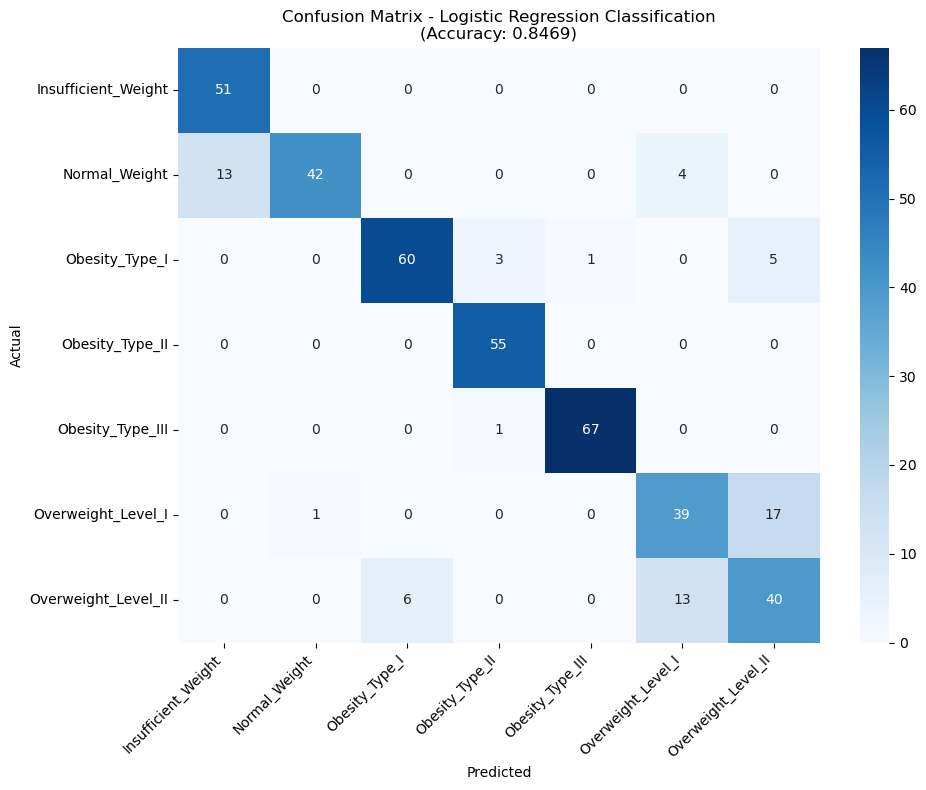

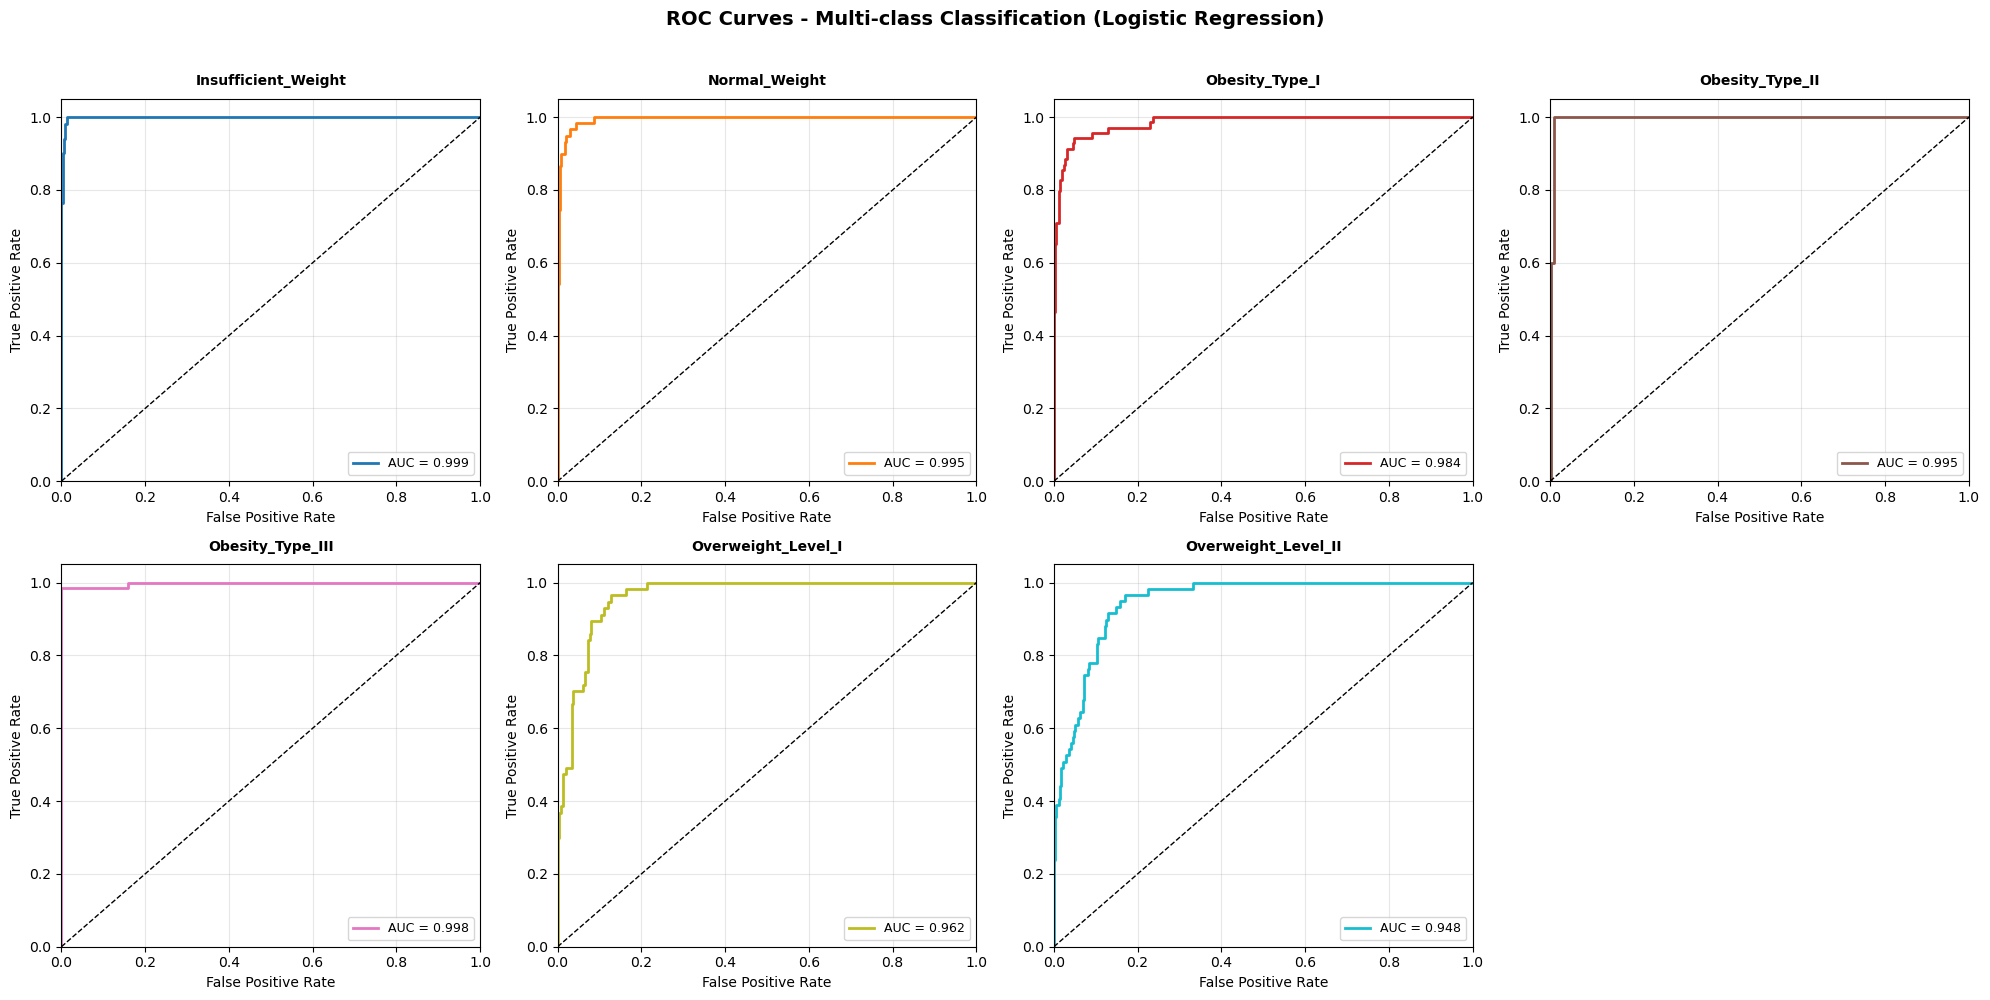


--- Feature Importance (Top 10) ---

Top 10 Most Important Features:
      Feature  Importance
       Weight    5.813566
       Height    1.504331
Gender_Female    0.867288
         FCVC    0.565593
          Age    0.362045
          FAF    0.355148
         CH2O    0.200292
          TUE    0.108530

*** Logistic Regression Classification Summary ***
Logistic Regression is a linear classifier that models the probability of each class
using the logistic function. For this obesity dataset with 8 selected features,
the model achieved 0.8469 accuracy with an average AUC of 0.9830.
The 5-fold cross-validation score of 0.8475 (±0.0277)
indicates good model consistency across different data splits.


==== Random Forest Classification ====

Classification Metrics (Random Forest with 8 features):
Accuracy:  0.9522
Precision: 0.9530
Recall:    0.9522
F1-Score:  0.9521

5-Fold Cross-Validation:
Mean: 0.9353 (±0.0090)
Scores: ['0.9323', '0.9522', '0.9280', '0.9280', '0.9360']

Detailed Classifi

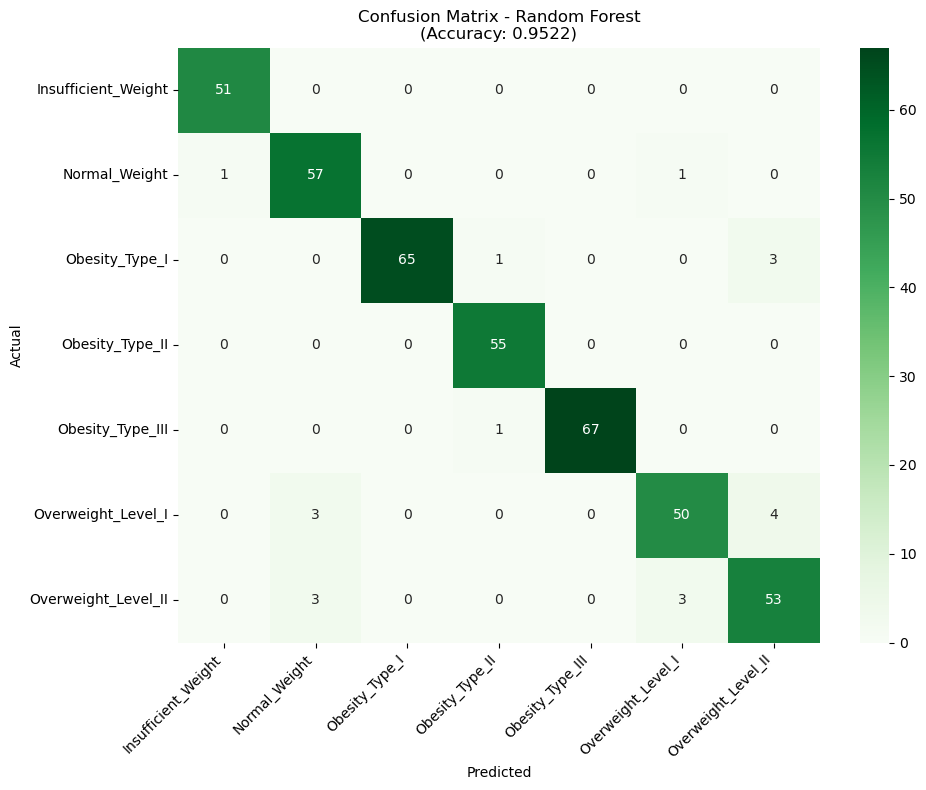

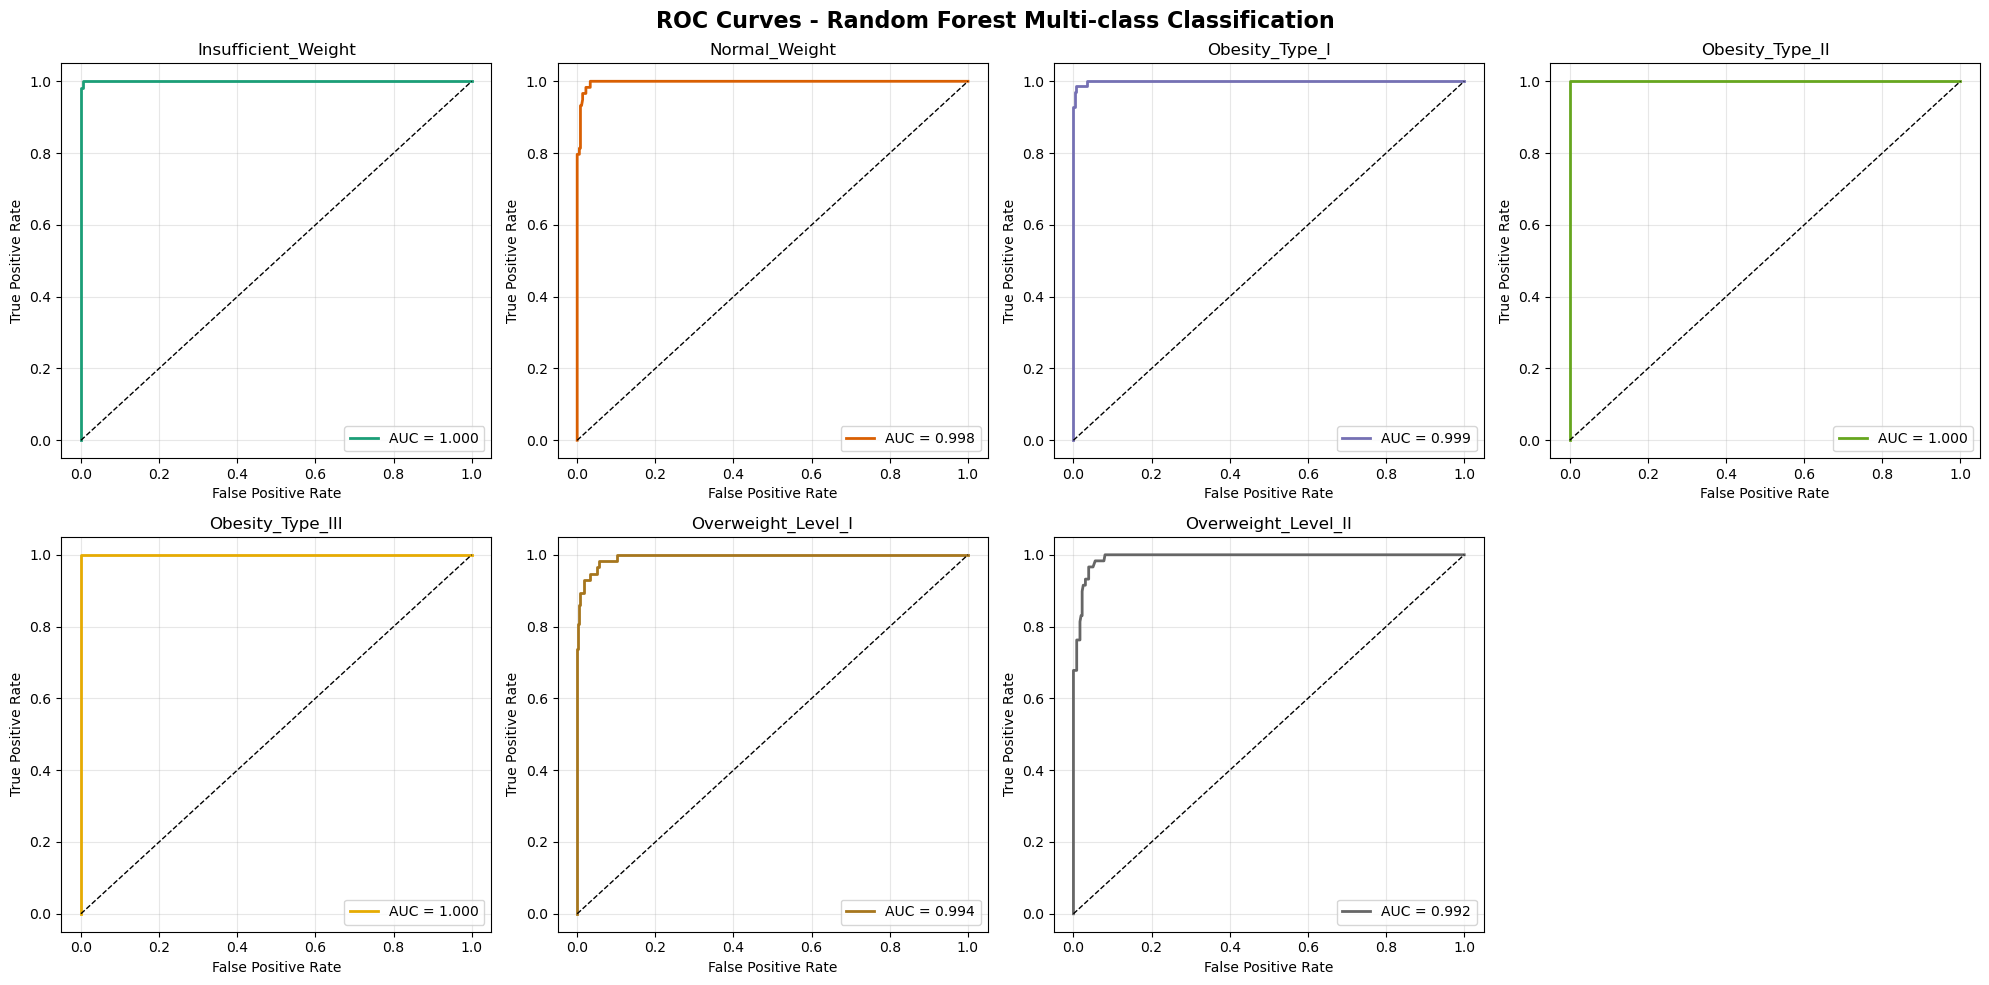


--- Feature Importance (Top 10) ---
      Feature  Importance
       Weight    0.374158
       Height    0.127019
          Age    0.125307
         FCVC    0.107113
          FAF    0.071102
          TUE    0.068917
         CH2O    0.066135
Gender_Female    0.060249
5. HYPERPARAMETER TUNING

 ==== Hyperparameter Tuning for KNN ====

Running Grid Search 5 fold cross validation
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Tuned Model Performance:
Accuracy: 0.8708
Precision: 0.8688
Recall: 0.8708
F1-Score: 0.8690

Impact of Hyperparameter Tuning
                    Model  Accuracy  Precision   Recall  F1-Score
      Before Tuning (k=5)  0.770335   0.766691 0.770335  0.760589
After Tuning (GridSearch)  0.870813   0.868847 0.870813  0.869016

Findings:
Accuracy improvement: +0.1005
Best k value: 3
Best weighting: distance
Best distance metric: manhattan
Since accuracy improvement is +0.1005, we can expect significant improvement from hyperparameter tuning


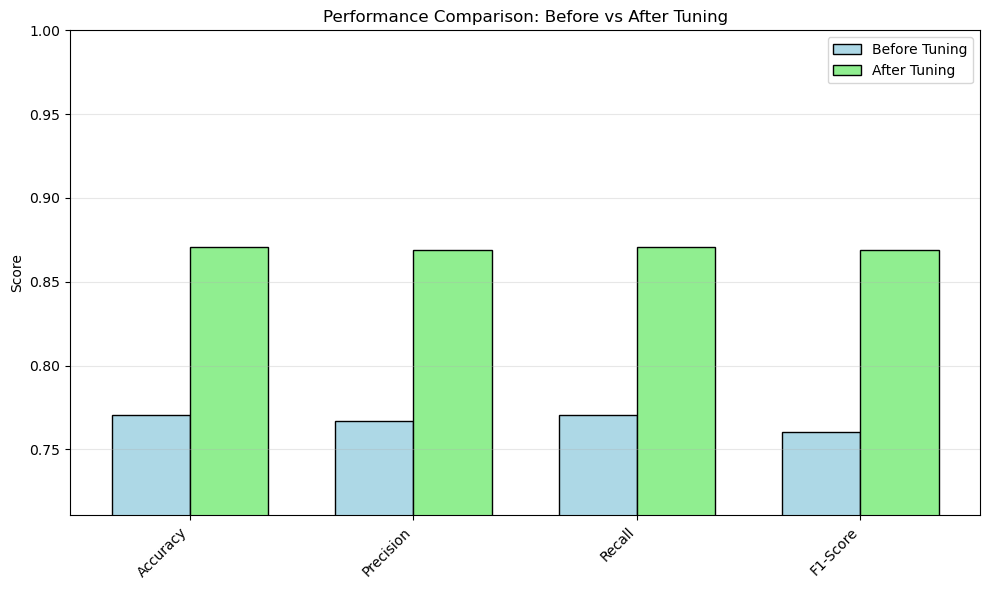


 ==== Hyperparameter Tuning for Random Forest ====
Fitting 3 folds for each of 81 candidates, totalling 243 fits

Tuned Model Performance:
Accuracy:  0.9498
Precision: 0.9515
Recall:    0.9498
F1-Score:  0.9496

Impact of Hyperparameter Tuning
                    Model  Accuracy  Precision   Recall  F1-Score
            Before Tuning  0.952153   0.953026 0.952153  0.952145
After Tuning (GridSearch)  0.949761   0.951469 0.949761  0.949619

Findings:
Accuracy improvement: -0.0024
Best params: {'max_depth': None, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 500}


{'knn_accuracy': 0.7703349282296651,
 'lr_accuracy': 0.84688995215311,
 'rf_accuracy': 0.9521531100478469,
 'knn_cv_mean': np.float64(0.7635697211155378),
 'lr_auc_avg': np.float64(0.9830402521305042),
 'rf_auc_avg': np.float64(0.9976084250276018),
 'rf_tuned_accuracy': 0.9497607655502392,
 'knn_tuned_accuracy': 0.8708133971291866}

In [2]:
data, train_data, valid_data, test_data = load_and_split_data()

clustering_results = clustering_analysis(train_data)
outlier_results = outlier_detection(train_data)
feature_selection_results = feature_selection(train_data, valid_data, test_data)
classification_results = classification(train_data, valid_data, test_data, feature_selection_results)
tuning_results = hyperparameter_tuning(classification_results)

summary_metrics = {
    'knn_accuracy': classification_results['knn']['accuracy'],
    'lr_accuracy': classification_results['logistic_regression']['accuracy'],
    'rf_accuracy': classification_results['random_forest']['accuracy'],
    'knn_cv_mean': classification_results['knn']['cv_mean'],
    'lr_auc_avg': classification_results['logistic_regression']['roc_auc_avg'],
    'rf_auc_avg': classification_results['random_forest']['roc_auc_avg'],
    'rf_tuned_accuracy': tuning_results['random_forest_tuned']['tuned_accuracy'],
    'knn_tuned_accuracy': tuning_results['knn_tuned']['tuned_accuracy'],
}
summary_metrics
